In [1]:
from __future__ import print_function, division
from builtins import range

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [3]:
import keras.backend as K

In [4]:
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

In [5]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [6]:
# load in pre-tained word vectors
print("Loading word vectors...")
word2vec = {}
with open(os.path.join('data/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [7]:
# prepare the text smaples and their labels
print('Loading in comments...')

train = pd.read_csv('data/train.csv')
sentences = train['comment_text'].fillna('DUMMY_VALUE').values
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
targets = train[possible_labels].values

Loading in comments...


In [8]:
# convert the sentences into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [9]:
print('max sequence length: ', max(len(s) for s in sentences))
print('min sequence length: ', min(len(s) for s in sentences))
s = sorted(len(s) for s in sequences)
print('median sequence length: ', s[len(s) // 2])
print('max word index: ', max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length:  5000
min sequence length:  6
median sequence length:  35
max word index:  19999


In [10]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [11]:
# pad sequence so that we get N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ', data.shape)

Shape of data tensor:  (159571, 100)


In [12]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) +1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [13]:
from sklearn.model_selection import train_test_split    
from sklearn.preprocessing import MinMaxScaler

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=VALIDATION_SPLIT, random_state=101)

In [15]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [16]:
print('Building model...')
import time
start_time = time.time()
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
# x = Bidirectional(LSTM(15, return_sequences=True))(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)
print("--- %s seconds ---" % (time.time() - start_time))

Building model...
--- 0.360271692276001 seconds ---


In [17]:
start_time = time.time()
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.01),
    metrics=['accuracy']
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.01776289939880371 seconds ---


In [18]:
print('Training model...')
start_time = time.time()
r = model.fit(
    X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test)
)
print("--- %s seconds ---" % (time.time() - start_time))

Training model...
Epoch 1/10
998/998 [==============================] - 486s 485ms/step - loss: 0.1223 - accuracy: 0.9352 - val_loss: 0.0572 - val_accuracy: 0.9935
Epoch 2/10
998/998 [==============================] - 558s 559ms/step - loss: 0.0554 - accuracy: 0.9938 - val_loss: 0.0544 - val_accuracy: 0.9912
Epoch 3/10
998/998 [==============================] - 522s 523ms/step - loss: 0.0515 - accuracy: 0.9894 - val_loss: 0.0536 - val_accuracy: 0.9906
Epoch 4/10
998/998 [==============================] - 486s 487ms/step - loss: 0.0500 - accuracy: 0.9858 - val_loss: 0.0548 - val_accuracy: 0.9881
Epoch 5/10
998/998 [==============================] - 522s 523ms/step - loss: 0.0491 - accuracy: 0.9825 - val_loss: 0.0549 - val_accuracy: 0.9682
Epoch 6/10
998/998 [==============================] - 532s 533ms/step - loss: 0.0483 - accuracy: 0.9817 - val_loss: 0.0526 - val_accuracy: 0.9837
Epoch 7/10
998/998 [==============================] - 515s 516ms/step - loss: 0.0474 - accuracy: 0.9828 - 

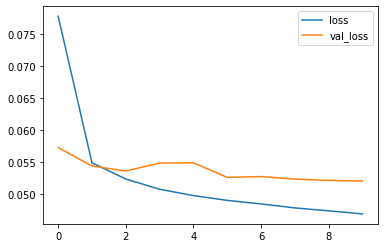

In [19]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

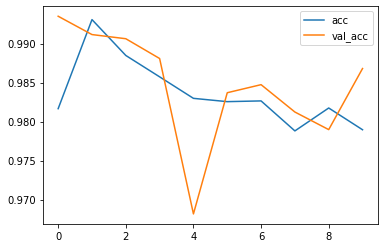

In [20]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [21]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9800884166176238


In [22]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

In [23]:
start_time = time.time()
probability = model.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 99.21058368682861 seconds ---


In [24]:
thresh = 0.4
predictions = np.array([[1 if i > thresh else 0 for i in j] for j in probability])

In [25]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      3087
           1       0.48      0.38      0.42       320
           2       0.79      0.79      0.79      1720
           3       0.00      0.00      0.00       104
           4       0.69      0.73      0.71      1580
           5       0.59      0.45      0.51       275

   micro avg       0.74      0.72      0.73      7086
   macro avg       0.55      0.52      0.53      7086
weighted avg       0.73      0.72      0.73      7086
 samples avg       0.07      0.07      0.06      7086



/home/ahsan/anaconda3/envs/attack_classify/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ahsan/anaconda3/envs/attack_classify/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
